# Model Training

Train multiple ML models, apply hyperparameter tuning using **GridSearchCV**, and evaludate performance to select the best model.

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import joblib

In [2]:
# Load processed dataset
df = pd.read_csv("../data/processed/processed_churn.csv")

print("Dataset shape: ", df.shape)
df.head()

Dataset shape:  (7021, 47)


,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-1.282728,-1.164135,-0.997334,No
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.062387,-0.262811,-0.176352,No
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,-1.241967,-0.365914,-0.962766,Yes
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.510759,-0.750058,-0.197874,No
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,-1.241967,0.194503,-0.943562,Yes


In [3]:
# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print("Train shape: ", X_train.shape, " Test shape: ", X_test.shape)

Train shape:  (5616, 46)  Test shape:  (1405, 46)


In [4]:
# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [5]:
# Define parameter grids for GridSearch
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5]
}

param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

In [6]:
# Initialize GridSearch for models
grid_searches = {}

grid_searches['Logistic Regression'] = GridSearchCV(LogisticRegression(max_iter=500), param_grid_lr, cv=5, scoring='f1')
grid_searches['Random Forest'] = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1')
grid_searches['XGBoost'] = GridSearchCV(XGBClassifier(random_state=42, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='f1')


In [7]:
# Fit models
best_models = {}
for name, grid in grid_searches.items():
    print(f"Running GridSearch for {name}..")
    grid.fit(X_train, y_train)
    print(f"Best Params for {name}: {grid.best_params_}")
    best_models[name] = grid.best_estimator_

Running GridSearch for Logistic Regression..
Best Params for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Running GridSearch for Random Forest..
Best Params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Running GridSearch for XGBoost..
Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [10]:
print(best_models)

{'Logistic Regression': LogisticRegression(C=10, max_iter=500, solver='liblinear'), 'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)}


In [8]:
# Evaludate tuned models
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} Results: ")
    print(classification_report(y_test, y_pred))
    print("Accuracy: ", accuracy_score(y_test, y_pred))


Logistic Regression Results: 
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.53      0.59       372

    accuracy                           0.80      1405
   macro avg       0.75      0.71      0.73      1405
weighted avg       0.79      0.80      0.80      1405

Accuracy:  0.802846975088968

Random Forest Results: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.49      0.57       372

    accuracy                           0.80      1405
   macro avg       0.75      0.70      0.72      1405
weighted avg       0.79      0.80      0.79      1405

Accuracy:  0.798576512455516

XGBoost Results: 
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1033
           1       0.67      0.51      0.58       372

    accuracy                           0.80      

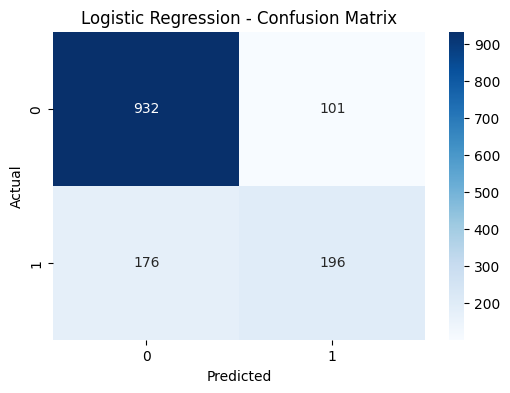

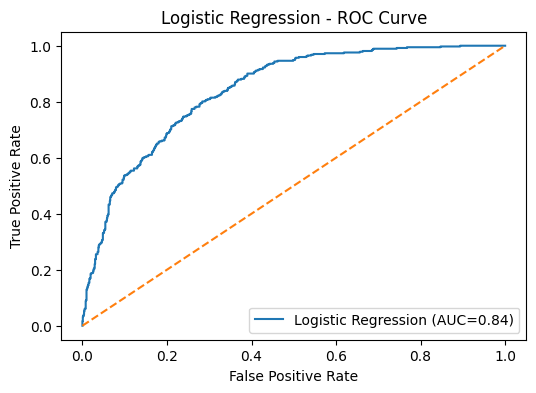

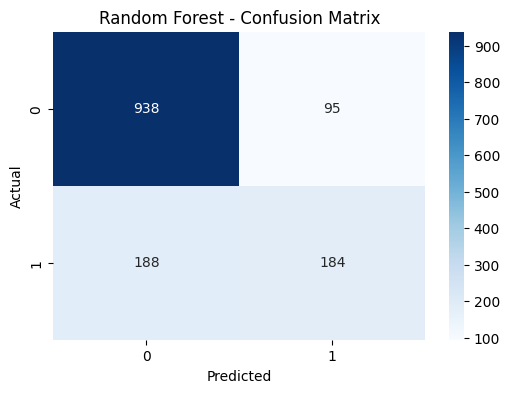

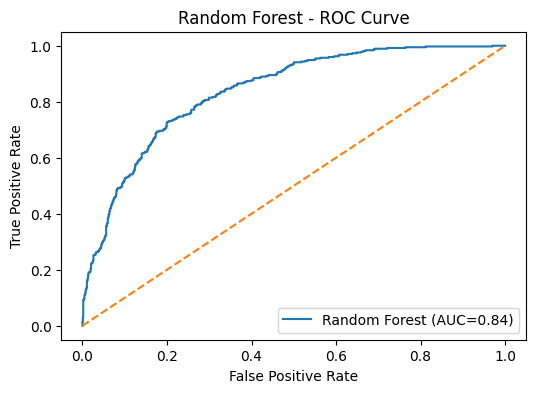

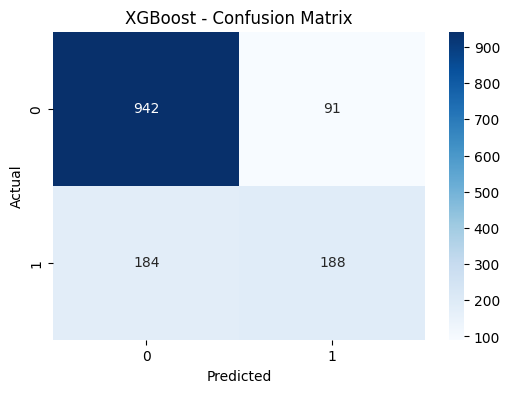

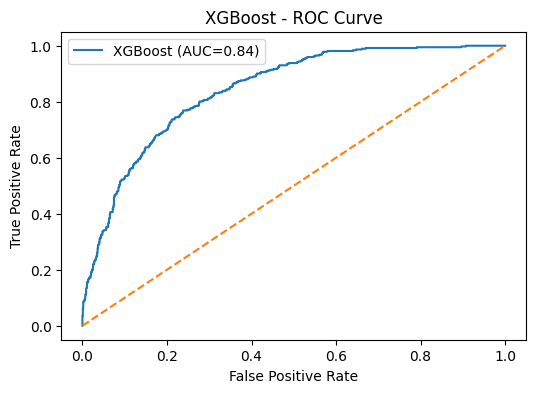

In [13]:
# Plot confusion matrix and ROC for each model
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")
        plt.plot([0,1],[0,1], '--' )
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.show()


In [17]:
# Select best overall model (based on ROC-AUC)
best_model = max(best_models.items(), key=lambda x:roc_auc_score(y_test, x[1].predict_proba(X_test)[:,1]))
print(f"\nBest Overall Model: {best_model[0]}")


Best Overall Model: XGBoost


In [18]:
# Save best model to disk
joblib.dump(best_model[1], "../models/churn_model.pkl")
print("Best model saved as churn_model.pkl")

Best model saved as churn_model.pkl
